In [1]:
import polars as pl

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
url_01 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'
url_02 = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'

df = pl.read_parquet(url_01)
df_02 = pl.read_parquet(url_02)

# Q1

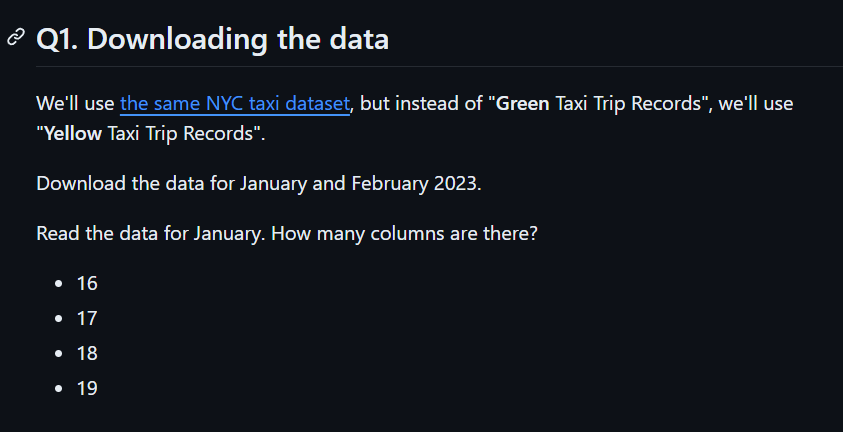

## Answer

In [3]:
df.shape[1]

19

# Q2

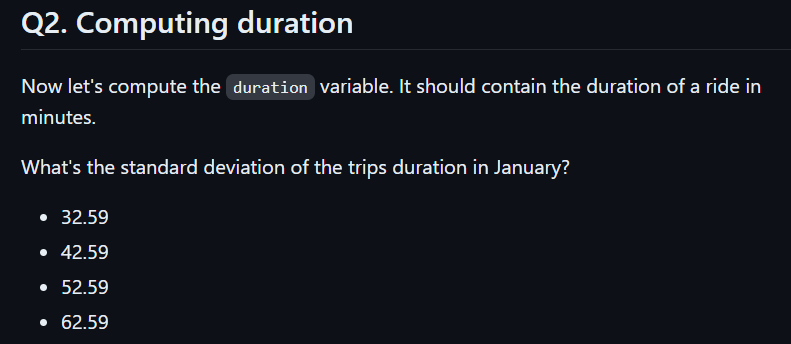

In [4]:
df = (
    df
    .with_columns(
        duration=(pl.col('tpep_dropoff_datetime') - pl.col('tpep_pickup_datetime')).dt.total_minutes()
    )
)

## Answer

In [5]:
round(df['duration'].std(), 2)

42.59

# Q3

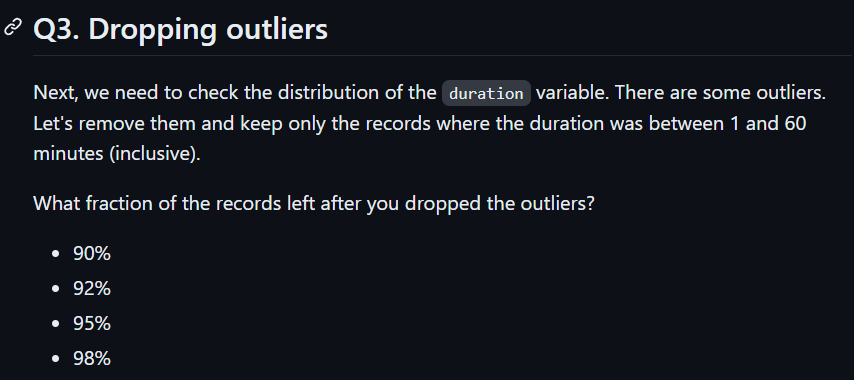

In [6]:
initial_size = df.shape[0]

In [7]:
df = (
    df
    .filter(
        pl.col('duration').is_between(1, 60)
    )
)

In [8]:
df['duration'].min(), df['duration'].max()

(1, 60)

## Answer

In [9]:
'{:.0%}'.format(df.shape[0] / initial_size)

'98%'

# Q4

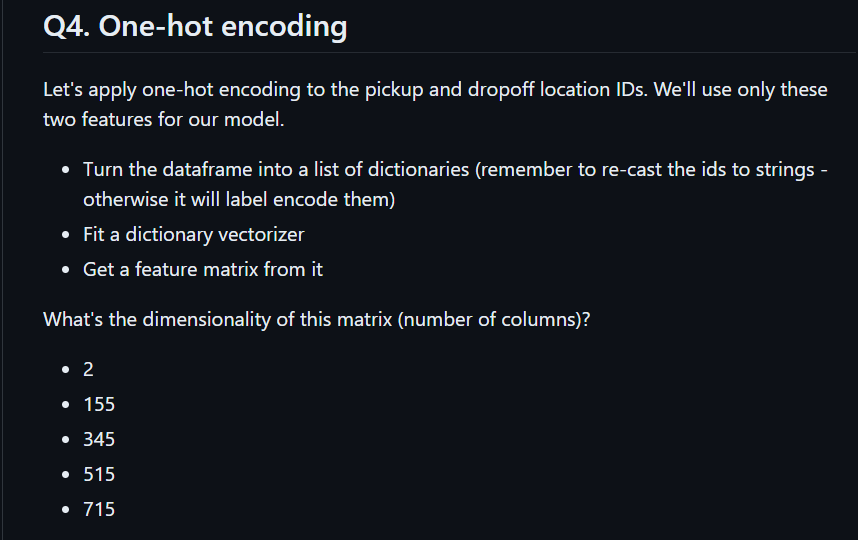

In [10]:
train = (
    df
    .select(
        pl.col('PULocationID', 'DOLocationID').cast(pl.Utf8),
    )
    .to_dicts()
)

In [11]:
dv = DictVectorizer()
X_train = dv.fit_transform(train)

In [12]:
train[:10]

[{'PULocationID': '161', 'DOLocationID': '141'},
 {'PULocationID': '43', 'DOLocationID': '237'},
 {'PULocationID': '48', 'DOLocationID': '238'},
 {'PULocationID': '138', 'DOLocationID': '7'},
 {'PULocationID': '107', 'DOLocationID': '79'},
 {'PULocationID': '161', 'DOLocationID': '137'},
 {'PULocationID': '239', 'DOLocationID': '143'},
 {'PULocationID': '142', 'DOLocationID': '200'},
 {'PULocationID': '164', 'DOLocationID': '236'},
 {'PULocationID': '141', 'DOLocationID': '107'}]

In [13]:
dv.feature_names_[:10]

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11']

In [14]:
X_train

<3011044x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6022088 stored elements in Compressed Sparse Row format>

## Answer

In [15]:
X_train.shape[1]

515

## Note

I did use `DictVectorizer` as the question asked but I really think one should use `OneHotEncoder` instead because it has a lot more features for example limiting the number of categories and dealing with new categories not present in the traininng dataset and also not needing conversion do dict and thus avoiding copying the data in memory. Regardless, the answer is the same.

In [16]:
train2 = (
    df
    .select(
        pl.col('PULocationID', 'DOLocationID').cast(pl.Utf8),
    )
)

ohe = OneHotEncoder()
X_train2 = ohe.fit_transform(train2)

X_train2.shape[1]

515

# Q5

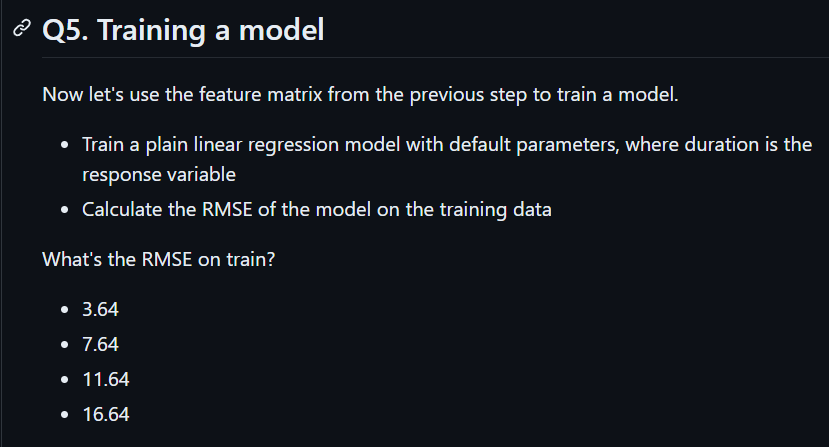

In [17]:
y_train = df['duration']

In [18]:
model = LinearRegression().fit(X_train, y_train)

## Answer

In [19]:
y_pred = model.predict(X_train)

In [20]:
round(root_mean_squared_error(y_train, y_pred), 2)

7.69

# Q6

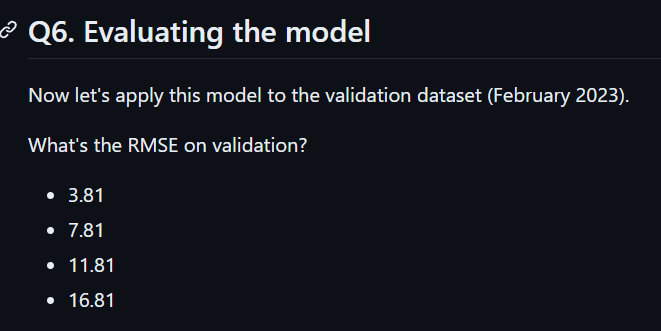

In [21]:
test = (
    df_02
    .select(
        pl.col('PULocationID', 'DOLocationID').cast(pl.Utf8),
        (pl.col('tpep_dropoff_datetime') - pl.col('tpep_pickup_datetime')).dt.total_minutes().alias('duration')
    )
    .filter(
        pl.col('duration').is_between(1, 60)
    )
)

In [22]:
X_teste = (
    dv
    .transform(
        test
        .select('PULocationID', 'DOLocationID')
        .to_dicts()
    )    
)

In [23]:
y_pred_teste = model.predict(X_teste)

In [24]:
round(root_mean_squared_error(test['duration'], y_pred_teste), 2)

7.87